# 批量归一化

很深的层，必不可少

- 损失在后面，则后面的层训练更快
- 数据在最底部
    - 底部层训练较慢
    - 底部层一变化，所有的层都会跟着变
    - 顶层网络收敛快，但是下面一变，上面就需要重新收敛
- 避免顶层网络重复训练

## 批量归一化

- 固定批量中的均值和方差

$$\mu_B=\frac{1}{|B|}\sum_{i\in B}(x_i-\mu)^2+\epsilon\qquad \epsilon\quad\text{防止除零错误}$$

$$x_{i+1}=\gamma \frac{x_i-\mu_B}{\delta_B}+\beta$$

$\gamma\beta$ 可学习的参数，微调均值和方差以适应特征结构

## 批量归一化层

- 作用在
    - 全连接和卷积的输出上，激活函数前
    - 全连接和卷积层的输入上
- 全连接作用在特征维度
- 卷积层作用在通道维

## 作用

- 论文指出减少内部协变量的转移
- 后续论文指出其可以通过在内部的小批量引入噪声来控制模型复杂度
    - $\mu_B\quad\delta_B$ 是随机的
    - 没必要和丢弃法混合使用

**固定住小批量的均值和方差，学习出合适的偏移和缩放**

**可以使用更大的学习率，加速收敛，但是一般不改变学习的精度**

In [1]:
import os
import time
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
%matplotlib inline
backend_inline.set_matplotlib_formats('svg')

In [2]:
""" 计算batch_norm """
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # moving_mean, moving_var 全局的均值和方差
    if not torch.is_grad_enabled(): # 推理阶段
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4) # 要求是 Linear或者Conv2d
        if len(X.shape) == 2: # Linear
            mean = X.mean(dim=0) # 0:batch_size 1:feature
            var = ((X - mean)**2).mean(dim=0)
            # Output : nx1
        else: # Conv2d
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 0:batch_size 1:channels 2:Height 3:Weight
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
            # Output : 1xnx1x1
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean # 一阶互补滤波
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data # 不要梯度   

In [3]:
""" 归一化层 """
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 使用 Parameter 自动更新权重
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.ones(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)
        
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, 10e-5, 0.9)
        return Y

In [4]:
class Reshape(torch.nn.Module):
    def forward(self, X):
        return X.view((-1, 1, 28, 28))
""" 用于LeNet """
net = torch.nn.Sequential(
    Reshape(),
    # 由于数据集是28x28，填充到32x32应用LeNet-5
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    BatchNorm(6, num_dims=4),
    torch.nn.ReLU(), # 那个时候没有 ReLU
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(), # 保持第一个维度（批量），后面全部展平
    torch.nn.Linear(16 * 5 * 5, 120),
    BatchNorm(120, num_dims=2),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)

In [5]:
resize = None
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.ToTensor()
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 2.086, train_acc : 0.7934 test_acc : 0.8404
Epoch 2, Using Time : 1.990, train_acc : 0.8625 test_acc : 0.8410
Epoch 3, Using Time : 2.019, train_acc : 0.8789 test_acc : 0.8522
Epoch 4, Using Time : 1.997, train_acc : 0.8894 test_acc : 0.8645
Epoch 5, Using Time : 2.034, train_acc : 0.8976 test_acc : 0.8644
Epoch 6, Using Time : 2.057, train_acc : 0.9010 test_acc : 0.8751
Epoch 7, Using Time : 2.026, train_acc : 0.9072 test_acc : 0.8738
Epoch 8, Using Time : 2.008, train_acc : 0.9109 test_acc : 0.8900
Epoch 9, Using Time : 2.067, train_acc : 0.9152 test_acc : 0.8683
Epoch 10, Using Time : 1.995, train_acc : 0.9183 test_acc : 0.8930
Test accuracy : 0.893
29587.0 examples/sec on Tesla T4
Total Time : 25.435562


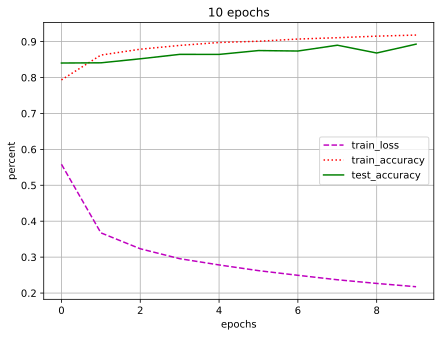

In [8]:
lr, num_epochs = 0.5, 10
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

# QA

- Xavier 用于初始化，BatchNormalization 用于每一层
- BatchNormalization 一般用于深层网络
- BatchNormalization 增加梯度大小，可以使用更大的 Learning Rate